<a href="https://colab.research.google.com/github/KethlynDiniz/Imoveis_SP/blob/main/Imoveis_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Bibliotecas utilizadas:

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Base de vendas de Imoveis em SP

 Iremos tentar predizer quais são os valores dos imóveis segundo alguns dados que temos, por exemplo:

      ▪ Localização
      ▪ Metragem
      ▪ Quartos
      ▪ Banheiros
      ▪ Vagas

 Além disso traremos informações do IBGE como renda per capita para nos ajudar nas métricas

#Parte 1 -Tratamento Inicial

 - 1 passo: Limpar base de dados excluindo linhas sem rua e bairro
 - 2 passo: Separar 'R$' do número na coluna 'Valor'
 - 3 passo: Identificar o que é locação e o que é venda
 - 4 passo: Retirar colunas que não fazem sentido no nosso tratamento de dados

###◾Limpar base de dados excluindo linhas sem rua e bairro

In [82]:
url = "https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv"
dados = pd.read_csv(url)
dados.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


In [83]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


######Identificando linhas sem rua ou bairro

In [84]:
dados_sem_rua = dados[dados.isnull().any(axis=1)]
dados_sem_rua

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
11,NaN,Jardim Luzitânia,São Paulo,436,4,3,3,R$ 15.000
31,NaN,Parque da Lapa,São Paulo,220,4,4,3,R$ 849.000
56,NaN,Chácara Santo Antônio (Zona Sul),São Paulo,190,2,2,2,R$ 1.100.000
57,NaN,Jardim Guedala,São Paulo,650,4,6,4,R$ 5.500.000
...,...,...,...,...,...,...,...,...
9963,NaN,Jardim Petrópolis,São Paulo,423,5,7,6,R$ 2.800.000
9989,NaN,Parque Alves de Lima,São Paulo,127,2,1,2,R$ 400.000
9991,NaN,Vila Formosa,São Paulo,145,3,2,3,R$ 750.000
9995,NaN,Jardim Leonor,São Paulo,1350,5,9,7,R$ 9.500.000


In [85]:
dados_sem_rua.Bairro.value_counts()

Jardim Guedala                      190
Alto de Pinheiros                   169
Jardim Paulista                     138
Jardim Europa                       128
Jardim Leonor                       118
                                   ... 
Jardim do Colégio (Zona Norte)        1
Alto da Boa Vista                     1
Jardim Aeroporto                      1
Conjunto Residencial Vista Verde      1
Jardim Santo Elias                    1
Name: Bairro, Length: 394, dtype: int64

######Droparemos essas linhas pois sem essas informações não conseguiremos vincular aos dados do IBGE

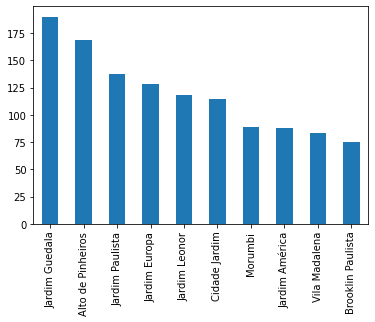

In [86]:
dados_sem_rua = dados_sem_rua["Bairro"].value_counts()
dados_sem_rua.head(10).plot.bar()

In [87]:
dados_2 = dados.dropna()
dados_2

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000
...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


######De uma base de dados de aproximadamente 10000 linhas, depois do saneamento estamos com aproximadamente 6562 linhas. Isso significa que praticamente 50% dos dados estavam incompletos o que dificulta nossas analises.

In [88]:
dados_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6562 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6562 non-null   object
 1   Bairro     6562 non-null   object
 2   Cidade     6562 non-null   object
 3   Metragem   6562 non-null   int64 
 4   Quartos    6562 non-null   int64 
 5   Banheiros  6562 non-null   int64 
 6   Vagas      6562 non-null   int64 
 7   Valor      6562 non-null   object
dtypes: int64(4), object(4)
memory usage: 461.4+ KB


###◾ Separar 'R$' do número na coluna 'Valor'

In [89]:
dados_2.Valor.str.split(expand = True)

,0,1,2
0,R$,7.000.000,None
1,R$,3.700.000,None
2,R$,380.000,None
4,R$,540.000,None
5,R$,1.980.000,None
...,...,...,...
10003,R$,665.000,None
10004,R$,2.300.000,None
10005,R$,1.050.000,None
10006,R$,2.200,/Mês


In [90]:
dados_2[['Moeda', 'Valor', 'Tipo_anuncio']] = dados_2.Valor.str.split(expand = True)
dados_2

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Moeda,Tipo_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7.000.000,R$,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3.700.000,R$,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380.000,R$,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540.000,R$,None
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1.980.000,R$,None
...,...,...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665.000,R$,None
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,2.300.000,R$,None
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1.050.000,R$,None
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,2.200,R$,/Mês


In [91]:
columns_title = ['Rua', 'Bairro', 'Cidade', 'Metragem', 'Quartos', 'Banheiros', 'Vagas', 'Moeda', 'Valor', 'Tipo_anuncio']
dados_2 = dados_2.reindex(columns = columns_title)
dados_2

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7.000.000,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3.700.000,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380.000,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540.000,None
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1.980.000,None
...,...,...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665.000,None
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2.300.000,None
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1.050.000,None
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$,2.200,/Mês


In [92]:
dados_2.Valor = dados_2.Valor.str.replace('.', '').astype(float)
dados_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,None
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,None
...,...,...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,None
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,None
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,None
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$,2200.00,/Mês


###✴ Identificando Locação e Venda

In [93]:
dados_2.Tipo_anuncio.unique()

array([None, '/Mês'], dtype=object)

In [94]:
dados_2.Tipo_anuncio.value_counts()

/Mês    465
Name: Tipo_anuncio, dtype: int64

In [95]:
dados_2.Tipo_anuncio.replace(to_replace=[None], value='Venda', inplace=True)
dados_2.Tipo_anuncio.replace(to_replace='/Mês', value='Locação', inplace=True)
dados_2.sample(10)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
4321,Rua Montezuma,Jardim das Bandeiras,São Paulo,305,4,5,4,R$,4800000.00,Venda
62,"Avenida João XXIII, 925",Vila Formosa,São Paulo,225,2,2,2,R$,780000.00,Venda
9889,Rua Doutor Erasmo Teixeira de Assunção,Jardim Leonor,São Paulo,487,4,4,4,R$,1800000.00,Venda
8265,Rua Eduardo da Silva Magalhães,Parque Continental,São Paulo,220,4,4,4,R$,1200000.00,Venda
9855,"Avenida Antônio de Souza Noschese, 996",Parque Continental,São Paulo,201,3,5,3,R$,990000.00,Venda
3434,Rua Paulo César,Vila Mazzei,São Paulo,230,4,4,5,R$,1330000.00,Venda
8501,"Rua Roque Giangrande Filho, 1",Jardim Itapeva,São Paulo,123,2,2,2,R$,530000.00,Venda
2891,"Rua da Dança Cigana, 394",Jardim Vaz de Lima,São Paulo,100,3,1,1,R$,445000.00,Venda
4498,Rua Guaianaz da Fonseca,Vila Madalena,São Paulo,140,2,2,1,R$,1280000.00,Venda
4396,Rua Brás Lourenço,Vila Mariana,São Paulo,208,5,1,4,R$,790000.00,Venda


In [96]:
pd.DataFrame(dados_2.Tipo_anuncio.value_counts())

,Tipo_anuncio
Venda,6097
Locação,465


##Com esses dados identificamos que alem de vendas, temos alguns imoveis para locação, visto isso, segue abaixo algumas considerações:

In [97]:
dados_aluguel = dados_2[dados_2['Tipo_anuncio'] == 'Locação']
dados_aluguel

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
151,Rua Fonseca da Costa,Bosque da Saúde,São Paulo,650,4,6,12,R$,11000.00,Locação
175,Rua Maestro Elias Lobo,Jardim Paulista,São Paulo,542,5,8,4,R$,25000.00,Locação
178,Rua Guararapes,Lapa,São Paulo,515,3,5,8,R$,30000.00,Locação
182,Rua Alvarenga,Butantã,São Paulo,400,4,3,4,R$,10000.00,Locação
184,"Rua Otávio Tarquínio de Sousa, 606",Campo Belo,São Paulo,160,3,4,2,R$,4500.00,Locação
...,...,...,...,...,...,...,...,...,...,...
9934,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,180,3,2,2,R$,2200.00,Locação
9941,"Rua Professor Henrique Neves Lefevre, 617",Jardim Petrópolis,São Paulo,205,3,2,1,R$,6000.00,Locação
9970,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$,2200.00,Locação
9977,"Rua Professor Henrique Neves Lefevre, 617",Jardim Petrópolis,São Paulo,205,3,2,1,R$,6000.00,Locação


In [98]:
pd.DataFrame(dados_aluguel.describe(include = 'all'))

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
count,465,465,465,465.00,465.00,465.00,465.00,465,465.00,465
unique,272,99,1,NaN,NaN,NaN,NaN,1,NaN,1
top,Rua Sampaio Vidal,Jardim Paulista,São Paulo,NaN,NaN,NaN,NaN,R$,NaN,Locação
freq,8,31,465,NaN,NaN,NaN,NaN,465,NaN,465
mean,NaN,NaN,NaN,479.39,3.74,4.51,4.86,NaN,18562.38,NaN
std,NaN,NaN,NaN,409.09,1.15,1.82,2.91,NaN,14381.55,NaN
min,NaN,NaN,NaN,60.00,1.00,1.00,1.00,NaN,1650.00,NaN
25%,NaN,NaN,NaN,280.00,3.00,3.00,3.00,NaN,9000.00,NaN
50%,NaN,NaN,NaN,405.00,4.00,4.00,4.00,NaN,15000.00,NaN
75%,NaN,NaN,NaN,595.00,4.00,6.00,6.00,NaN,25000.00,NaN


In [99]:
pd.DataFrame(dados_aluguel.Bairro.value_counts())

,Bairro
Jardim Paulista,31
Jardim América,26
Alto de Pinheiros,22
Cidade Jardim,20
Jardim Paulistano,20
...,...
Jardim Taboão,1
Jardim Sílvia (Zona Oeste),1
Vila Anglo Brasileira,1
Ibirapuera,1


In [100]:
dados_aluguel.Valor.mean()

18562.38064516129

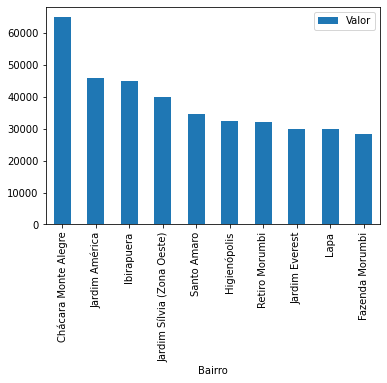

In [101]:
valor_aluguel = pd.DataFrame(dados_aluguel.groupby(['Bairro'])['Valor'].mean())
valor_aluguel.sort_values(by = 'Valor', ascending = False, inplace = True)
valor_aluguel.head(10).plot.bar()

✴ Chácara Monte Alegre tem apenas um imóvel com valor de locação 65mil reais, isso torna ele um outlier e fica em primeiro lugar na média de valor dos bairros.

In [102]:
dados_aluguel[dados_aluguel['Bairro'] == 'Chácara Monte Alegre']

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
924,Rua Marcondésia,Chácara Monte Alegre,São Paulo,800,4,6,5,R$,65000.00,Locação


In [103]:
top_bairros_aluguel = dados_aluguel.Bairro.value_counts()[:10].index
top_bairros_aluguel

Index(['Jardim Paulista', 'Jardim América', 'Alto de Pinheiros',
       'Cidade Jardim', 'Jardim Paulistano', 'Jardim Guedala',
       'Brooklin Paulista', 'Fazenda Morumbi', 'Vila Madalena', 'Pacaembu'],
      dtype='object')

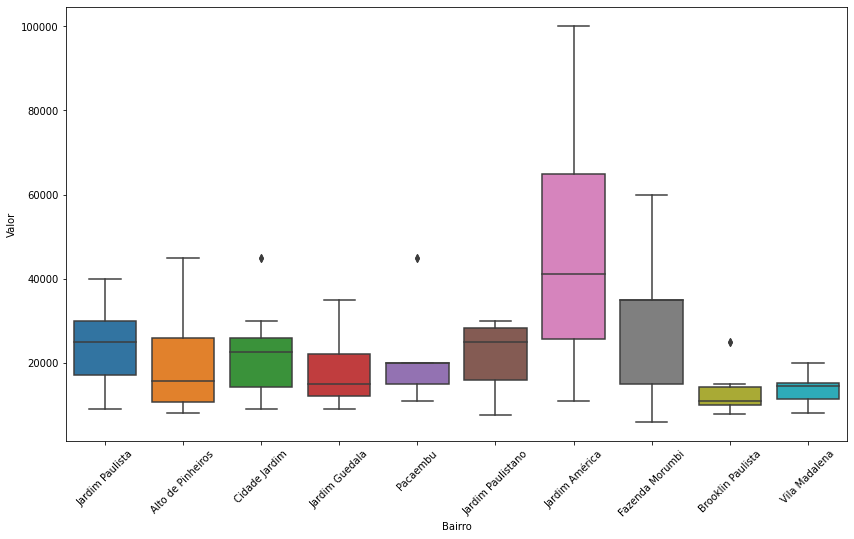

In [104]:
plt.figure(figsize = (14, 8))
ax1 = sns.boxplot(data = dados_aluguel.query('Bairro in @top_bairros_aluguel'), x = 'Bairro', y = 'Valor')
ax1.tick_params(axis = 'x', rotation = 45)
plt.show()

✴ Jardim América é um bairro que tem incidência de lojas e escritórios de alto padrão por isso o aluguel dessa região ficou disproporcional das outras.

#Parte 2 - Inclusão dos dados IBGE

#### Depois de limpar e fazer o saneamento da primeira lista de dados, vamos iniciar a inclusão de novos dados para enriquecer nossa analise. Iremos importar os dados do IBGE fazendo os seguintes passos:
 - 1 passo: Utilizar apenas dados vendas.
 - 2 passo: Analisar as informações do IBGE para a construção do modelo e eventual drop de informações superfluas
 - 3 passo: Retirar colunas que não fazem sentido no nosso tratamento de dados
 - 4 passo: Adequação de caracteres especiais

### ✴ Deixar base de dados apenas com as vendas.

In [66]:
dados_venda = dados_2[dados_2['Tipo_anuncio'] == 'Venda']
dados_venda

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda
...,...,...,...,...,...,...,...,...,...,...
10002,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,Venda
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,Venda
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,Venda
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,Venda


In [67]:
dados_venda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6097 entries, 0 to 10007
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rua           6097 non-null   object 
 1   Bairro        6097 non-null   object 
 2   Cidade        6097 non-null   object 
 3   Metragem      6097 non-null   int64  
 4   Quartos       6097 non-null   int64  
 5   Banheiros     6097 non-null   int64  
 6   Vagas         6097 non-null   int64  
 7   Moeda         6097 non-null   object 
 8   Valor         6097 non-null   float64
 9   Tipo_anuncio  6097 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 524.0+ KB


Dados IBGE

In [68]:
ibge_url = 'https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv'
ibge_sp = pd.read_csv(ibge_url, sep = ';', 
                      thousands='.', 
                      decimal=',', 
                      encoding='ISO-8859-1')
ibge_sp.dropna(how='all', axis=1, inplace=True)
ibge_sp.head()

,Cod_setor,Cod_Grandes Regiï¿½es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,355030801000001,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.01,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86
1,355030801000002,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,2.98,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94
2,355030801000003,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.31,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74
3,355030801000004,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.16,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24
4,355030801000005,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.14,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85


In [69]:
ibge_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cod_setor              18363 non-null  int64  
 1   Cod_Grandes Regiï¿½es  18363 non-null  int64  
 2   Nome_Grande_Regiao     18363 non-null  object 
 3   Cod_UF                 18363 non-null  int64  
 4   Nome_da_UF             18363 non-null  object 
 5   Cod_meso               18363 non-null  int64  
 6   Nome_da_meso           18363 non-null  object 
 7   Cod_micro              18363 non-null  int64  
 8   Nome_da_micro          18363 non-null  object 
 9   Cod_RM                 18363 non-null  int64  
 10  Nome_da_RM             18363 non-null  object 
 11  Cod_municipio          18363 non-null  int64  
 12  Nome_do_municipio      18363 non-null  object 
 13  Cod_distrito           18363 non-null  int64  
 14  Nome_do_distrito       18363 non-null  object 
 15  Co

Drop Colunas não utilizaveis

- Cod_Grandes Regiï¿½es
- Nome_Grande_Regiao
- Cod_UF
- Nome_da_UF
- Cod_meso
- Nome_da_meso
- Cod_micro
- Nome_da_micro
- Cod_RM
- Nome_da_RM
- Cod_municipio
- Nome_do_municipio
- Cod_distrito
- Nome_do_distrito
- Cod_subdistrito
- Nome_do_subdistrito
- Cod_bairro
- Nome_do_bairro
- Tipo_setor

Colunas para rename:
- Nome do Distrito para Nome_bairro

In [70]:
ibge_sp.drop(['Cod_Grandes Regiï¿½es', 'Nome_Grande_Regiao', 'Cod_UF', 'Nome_da_UF ', 'Cod_meso', 
              'Nome_da_meso', 'Cod_micro', 'Nome_da_micro', 'Cod_RM', 'Nome_da_RM', 'Cod_municipio',
              'Nome_do_municipio', 'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito', 'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro',
              'Tipo_setor', 'V004', 'V006', 'V008', 'V010', 'V011', 'V012'], axis = 1, inplace = True)
ibge_sp

,Cod_setor,Situacao_setor,V001,V002,V003,V005,V007,V009
0,355030801000001,1,266.00,800.00,3.01,2091.32,2164.55,1227.41
1,355030801000002,1,306.00,913.00,2.98,1650.09,1717.44,1045.78
2,355030801000003,1,189.00,625.00,3.31,1280.43,2349.53,902.97
3,355030801000004,1,181.00,572.00,3.16,1119.59,1859.13,869.09
4,355030801000005,1,240.00,754.00,3.14,1416.90,1581.66,917.71
...,...,...,...,...,...,...,...,...
18358,355030896000243,1,96.00,336.00,3.50,772.09,814.52,467.46
18359,355030896000244,1,54.00,209.00,3.87,692.50,812.93,439.33
18360,355030896000245,1,87.00,339.00,3.90,630.06,843.31,347.60
18361,355030896000246,1,38.00,163.00,4.29,597.37,908.00,397.76


In [71]:
pd.set_option('display.float_format', lambda x: '%.2f' % x )
ibge_sp

,Cod_setor,Situacao_setor,V001,V002,V003,V005,V007,V009
0,355030801000001,1,266.00,800.00,3.01,2091.32,2164.55,1227.41
1,355030801000002,1,306.00,913.00,2.98,1650.09,1717.44,1045.78
2,355030801000003,1,189.00,625.00,3.31,1280.43,2349.53,902.97
3,355030801000004,1,181.00,572.00,3.16,1119.59,1859.13,869.09
4,355030801000005,1,240.00,754.00,3.14,1416.90,1581.66,917.71
...,...,...,...,...,...,...,...,...
18358,355030896000243,1,96.00,336.00,3.50,772.09,814.52,467.46
18359,355030896000244,1,54.00,209.00,3.87,692.50,812.93,439.33
18360,355030896000245,1,87.00,339.00,3.90,630.06,843.31,347.60
18361,355030896000246,1,38.00,163.00,4.29,597.37,908.00,397.76


In [72]:
ibge_sp.describe()

,Cod_setor,Situacao_setor,V001,V002,V003,V005,V007,V009
count,18363.00,18363.00,18333.00,18333.00,18333.00,18333.00,18324.00,18363.00
mean,355030848919797.38,1.15,194.96,611.45,3.16,2160.19,2491.85,1413.45
std,26356206.31,0.95,93.52,313.26,0.50,2602.11,2865.92,1515.49
min,355030801000001.00,1.00,1.00,1.00,1.00,0.00,120.00,0.00
25%,355030827000076.50,1.00,134.00,406.00,2.91,814.13,1013.55,549.41
50%,355030846000144.00,1.00,190.00,583.00,3.21,1212.70,1435.89,817.35
75%,355030872000033.50,1.00,249.00,777.00,3.46,2411.54,2736.29,1619.34
max,355030896000247.00,8.00,954.00,3252.00,8.00,73312.50,78200.00,30825.93


#Parte 3 - Importação dos endereços para a partir da latitude e longitude conseguir vincular IBGE + Vendas *Imóveis*

#### Seguimos com o saneamento dos dados, agora na planilha de endereços que contem longitudo e latitude, dados importantes para vincular os dados do IBGE + Vendas Imóveis. Próximos passos:
 - 1 passo: Importar planilha.
 - 2 passo: Normalizar informações.
 - 3 passo: Filtrar apenas dados SP - São Paulo
 - 4 passo: Separar número de endereço e deixa-los todos em letras minúsculas
 - 5 passo: Juntar as 2 planilhas e excluir colunas sobressalentes

In [73]:
from google.colab import drive
drive.mount('/content/drive')
enderecos = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Imersão_Alura/enderecos.csv')
enderecos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
0,Rua,Armando Silveira,Rua Armando Silveira,NaN,Divisa,Santana do Livramento,RS,97573200.00,-30.88,-55.55
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45
2,Rua,Prefeito Agenor Barcelos Feio,Rua Prefeito Agenor Barcelos Feio,NaN,Registro,Santana do Livramento,RS,97571090.00,-30.86,-55.56
3,Rua,Sebastião Gomes,Rua Sebastião Gomes - até 59/60,59,Registro,Santana do Livramento,RS,97571374.00,-30.86,-55.55
4,Rua,Marquês do Alegrete,Rua Marquês do Alegrete,NaN,Parque das Águas,Santana do Livramento,RS,97571500.00,-30.86,-55.55
...,...,...,...,...,...,...,...,...,...,...
1113881,Quadra,4 Conjunto 7,Quadra 4 Conjunto 7,NaN,Setor Habitacional Vicente Pires - Trecho 3,Brasília,DF,72001381.00,-15.70,-47.87
1113882,Rodovia,Mario Tonolli,Rodovia Mario Tonolli,NaN,Morro Alto,Itupeva,SP,13297002.00,-23.19,-47.08
1113883,Avenida,das Torres,Avenida das Torres - de 6318 ao fim - lado par,6318,Lago Azul,Manaus,AM,69018156.00,-2.99,-59.99
1113884,Rua,Tiradentes,Rua Tiradentes - de 181 a 369 - lado ímpar,181,Vila Queiroz,Artur Nogueira,SP,13163000.00,-22.58,-47.17


In [74]:
enderecos_sp = enderecos.query("nome_localidade == 'São Paulo'")
enderecos_sp.sample(10)

,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
596100,Rua,Barão de Iguape,Rua Barão de Iguape - de 431/432 ao fim,NaN,Liberdade,São Paulo,SP,1507001.00,-23.56,-46.63
655855,Rua,Alfredo Pereira dos Santos,Rua Alfredo Pereira dos Santos,NaN,Vila Penteado,São Paulo,SP,2866165.00,-23.47,-46.68
582413,Rua,Maria Susano Polilo,Rua Maria Susano Polilo,NaN,Vila Rosaria,São Paulo,SP,8021300.00,-23.50,-46.44
554466,Estrada,"do M Boi Mirim, 820","Estrada do M Boi Mirim, 820",NaN,Jardim das Flores,São Paulo,SP,4905901.00,-3.42,-65.86
580640,Rua,Macaiá-Mirim,Rua Macaiá-Mirim,NaN,Santana,São Paulo,SP,2013080.00,-23.50,-46.64
592555,Rua,Seul,Rua Seul,NaN,Vila Carrão,São Paulo,SP,3441040.00,-23.55,-46.53
577697,Rua,José de Castro Lima Filho,Rua José de Castro Lima Filho,NaN,Vila Ema,São Paulo,SP,3276140.00,-23.58,-46.54
568027,Rua,Drava,Rua Drava,NaN,Vila Moinho Velho,São Paulo,SP,4283000.00,-23.61,-46.60
569246,Rua,Esmirna,Rua Esmirna,NaN,Vila Fanton,São Paulo,SP,5201230.00,-23.41,-46.74
555038,Rua,"Brigadeiro Tobias, 356","Rua Brigadeiro Tobias, 356",NaN,Centro,São Paulo,SP,1032901.00,-23.54,-46.64


In [75]:
enderecos_sp["rua"] = enderecos_sp["tipo_logr"] + " " + enderecos_sp["logr_nome"]
enderecos_sp["rua"] = enderecos_sp["rua"].str.lower().str.strip()   #lower para deixar minusculo #strip remove os espacos extras desnecessarios
enderecos_sp.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude,rua
594933,Rua,Verbos do Amor,Rua Verbos do Amor,NaN,Conjunto Residencial José Bonifácio,São Paulo,SP,8257170.00,-23.55,-46.43,rua verbos do amor
826455,Rua,Noventa e Cinco,Rua Noventa e Cinco,NaN,Vila Roseira II,São Paulo,SP,8466003.00,-23.56,-46.40,rua noventa e cinco
568606,Rua,Emanuele Saporiti,Rua Emanuele Saporiti,NaN,Vila Maria Alta,São Paulo,SP,2129070.00,-23.50,-46.59,rua emanuele saporiti
596805,Rua,Eduardo Sanchez,Rua Eduardo Sanchez,NaN,Cidade Tiradentes,São Paulo,SP,8475180.00,-23.59,-46.40,rua eduardo sanchez
592988,Rua,Soldado Isidro Matoso,Rua Soldado Isidro Matoso,NaN,Parque Novo Mundo,São Paulo,SP,2147050.00,-23.50,-46.56,rua soldado isidro matoso
587226,Rua,Pedro Osvaldo Contieri,Rua Pedro Osvaldo Contieri,NaN,Jardim Brasil (Zona Norte),São Paulo,SP,2227110.00,-23.47,-46.58,rua pedro osvaldo contieri
601749,Rua,José Gustavo Paiva,Rua José Gustavo Paiva,NaN,Jardim Ângela (Zona Leste),São Paulo,SP,3985075.00,-23.61,-46.52,rua josé gustavo paiva
585563,Rua,Osvaldo Libarino de Oliveira,Rua Osvaldo Libarino de Oliveira,NaN,Jardim São Jorge (Raposo Tavares),São Paulo,SP,5567180.00,-23.60,-46.78,rua osvaldo libarino de oliveira
588262,Galeria,Prestes Maia,Galeria Prestes Maia,NaN,Centro,São Paulo,SP,1007030.00,-23.68,-46.61,galeria prestes maia
603025,Rua,Orides de Andrade,Rua Orides de Andrade,NaN,Jardim Monjolo,São Paulo,SP,2961146.00,-23.50,-46.70,rua orides de andrade


In [76]:
dados_venda['apenas_rua'] = dados_venda['Rua'].str.extract(r'(^[\w ]+)')
dados_venda['apenas_rua'] = dados_venda["apenas_rua"].str.lower().str.strip()
dados_venda.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio,apenas_rua
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda,avenida itacira
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda,rua aurelia perez alvarez
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda,rua alba valdez
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda,rua tobias barreto
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda,rua graham bell


In [77]:
dados_geo = pd.merge(left = dados_venda, 
                     right = enderecos_sp[["rua", "cep", "latitude", "longitude"]], 
                     how = "left", left_on = "apenas_rua", right_on = "rua").drop_duplicates(subset=dados_venda.columns).query("cep > 0")
dados_geo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio,apenas_rua,rua,cep,latitude,longitude
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda,avenida itacira,avenida itacira,4061000.00,-23.62,-46.65
4,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda,rua aurelia perez alvarez,rua aurelia perez alvarez,4642020.00,-23.64,-46.69
5,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda,rua alba valdez,rua alba valdez,4845200.00,-23.75,-46.70
6,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda,rua tobias barreto,rua tobias barreto,3176000.00,-23.55,-46.59
8,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda,rua graham bell,rua graham bell,4737030.00,-23.59,-46.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10605,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,Venda,avenida odila,avenida odila,4058020.00,-23.61,-46.65
10607,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,Venda,rua tapuçu,rua tapuçu,4671185.00,-23.66,-46.69
10608,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,Venda,rua guararema,rua guararema,4136030.00,-23.41,-46.04
10610,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,Venda,rua estero belaco,rua estero belaco,4145020.00,-23.62,-46.63


✴ Depois de realizar o de-para nas planilhas Dados_venda e enderecos_sp excluimos as colunas que não necessitamos para não poluir nossa planilha.

In [78]:
dados_geo.drop(['apenas_rua', 'rua'], axis = 1, inplace = True)
dados_geo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio,cep,latitude,longitude
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda,4061000.00,-23.62,-46.65
4,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda,4642020.00,-23.64,-46.69
5,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda,4845200.00,-23.75,-46.70
6,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda,3176000.00,-23.55,-46.59
8,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda,4737030.00,-23.59,-46.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10605,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,Venda,4058020.00,-23.61,-46.65
10607,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,Venda,4671185.00,-23.66,-46.69
10608,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,Venda,4136030.00,-23.41,-46.04
10610,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,Venda,4145020.00,-23.62,-46.63


In [105]:
setor_censo_sp = gpd.read_file('/content/drive/MyDrive/Colab_Notebooks/Imersão_Alura/35SEE250GC_SIR.shp')
setor_censo_sp

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
0,98237.00,354100005000009,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,1,"POLYGON ((-46.41024 -24.01103, -46.41169 -24.0..."
1,98232.00,354100005000004,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,2,"POLYGON ((-46.41606 -24.00245, -46.41598 -24.0..."
2,98230.00,354100005000002,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,3,"POLYGON ((-46.41213 -24.00792, -46.41244 -24.0..."
3,98229.00,354100005000001,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,4,"POLYGON ((-46.41134 -24.00552, -46.41196 -24.0..."
4,98231.00,354100005000003,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,5,"POLYGON ((-46.41326 -24.00514, -46.41484 -24.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68291,133873.00,355730305000008,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68292,"POLYGON ((-46.95301 -22.28885, -46.95401 -22.2..."
68292,133874.00,355730305000009,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68293,"POLYGON ((-46.97846 -22.22911, -46.97545 -22.2..."
68293,133875.00,355730305000010,URBANO,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68294,"POLYGON ((-46.97514 -22.26519, -46.97416 -22.2..."
68294,133876.00,355730305000011,RURAL,35573030500,None,355730305,ESTIVA GERBI,3557303,ESTIVA GERBI,MOJI-MIRIM,CAMPINAS,None,None,68295,"POLYGON ((-46.94954 -22.26701, -46.94888 -22.2..."


In [106]:
dados_geo["Point"] = ""
for i in dados_geo.index:
    dados_geo["Point"][i] = Point(dados_geo["longitude"][i], dados_geo["latitude"][i])

dados_geo['setor_censo'] = dados_geo["Point"].map(
    lambda x: setor_censo_sp.loc[setor_censo_sp.contains(x), 'CD_GEOCODI'].values
).str[0]
dados_geo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio,cep,latitude,longitude,Point,setor_censo
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067
4,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023
5,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050
6,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050
8,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10605,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,Venda,4058020.00,-23.61,-46.65,POINT (-46.6472577 -23.6090928),355030877000099
10607,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,Venda,4671185.00,-23.66,-46.69,POINT (-46.6915206 -23.661018),355030816000087
10608,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,Venda,4136030.00,-23.41,-46.04,POINT (-46.0373872 -23.411688),351830505000002
10610,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,Venda,4145020.00,-23.62,-46.63,POINT (-46.632983 -23.6161237),355030877000052


In [107]:
dados_geo.dropna(inplace = True)

In [108]:
dados_geo.setor_censo = pd.to_numeric(dados_geo["setor_censo"])

In [109]:
dados_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5598 entries, 0 to 10611
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rua           5598 non-null   object 
 1   Bairro        5598 non-null   object 
 2   Cidade        5598 non-null   object 
 3   Metragem      5598 non-null   int64  
 4   Quartos       5598 non-null   int64  
 5   Banheiros     5598 non-null   int64  
 6   Vagas         5598 non-null   int64  
 7   Moeda         5598 non-null   object 
 8   Valor         5598 non-null   float64
 9   Tipo_anuncio  5598 non-null   object 
 10  cep           5598 non-null   float64
 11  latitude      5598 non-null   float64
 12  longitude     5598 non-null   float64
 13  Point         5598 non-null   object 
 14  setor_censo   5598 non-null   int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 699.8+ KB


In [166]:
dados_vendas_censo = pd.merge(left = dados_geo, right = ibge_sp,
                              how = "left", left_on = "setor_censo", right_on = "Cod_setor")
dados_vendas_censo

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,Tipo_anuncio,...,Point,setor_censo,Cod_setor,Situacao_setor,V001,V002,V003,V005,V007,V009
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,Venda,...,POINT (-46.6481622 -23.6157934),355030877000067,355030877000067.00,1.00,164.00,437.00,2.66,3158.96,5570.65,2096.19
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,Venda,...,POINT (-46.6883114 -23.6409612),355030871000023,355030871000023.00,1.00,136.00,425.00,3.13,7600.44,7890.53,4149.00
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,Venda,...,POINT (-46.6958895 -23.75299),355030830000050,355030830000050.00,1.00,142.00,493.00,3.47,805.13,1011.75,518.77
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,Venda,...,POINT (-46.5881729 -23.5499597),355030808000050,355030808000050.00,1.00,156.00,468.00,3.00,2338.05,2447.89,1543.29
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,Venda,...,POINT (-46.7600773 -23.5937964),355030865000169,355030865000169.00,1.00,107.00,376.00,3.51,1026.36,1143.96,735.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5593,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,Venda,...,POINT (-46.6472577 -23.6090928),355030877000099,355030877000099.00,1.00,256.00,720.00,2.81,4249.33,5180.14,2618.76
5594,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,Venda,...,POINT (-46.6915206 -23.661018),355030816000087,355030816000087.00,1.00,150.00,448.00,2.99,2425.09,2543.80,1561.58
5595,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$,2300000.00,Venda,...,POINT (-46.0373872 -23.411688),351830505000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5596,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,Venda,...,POINT (-46.632983 -23.6161237),355030877000052,355030877000052.00,1.00,400.00,1099.00,2.75,5650.20,5750.84,3459.68


In [167]:
dados_vendas_censo.drop(['Cod_setor'], axis = 1, inplace = True)
dados_vendas_censo.dropna(inplace = True)

#Parte 4 - Analise do nosso banco de dados.
 Identificar padrões que podem ser úteis para nosso próximo passo que será um Machine Learning

In [168]:
dados_vendas_censo['Valor_m2'] = dados_vendas_censo['Valor'] / dados_vendas_censo['Metragem']
dados_vendas_censo = dados_vendas_censo.reset_index()
dados_vendas_censo

,index,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Moeda,Valor,...,Point,setor_censo,Situacao_setor,V001,V002,V003,V005,V007,V009,Valor_m2
0,0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$,7000000.00,...,POINT (-46.6481622 -23.6157934),355030877000067,1.00,164.00,437.00,2.66,3158.96,5570.65,2096.19,7000.00
1,1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$,3700000.00,...,POINT (-46.6883114 -23.6409612),355030871000023,1.00,136.00,425.00,3.13,7600.44,7890.53,4149.00,7459.68
2,2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$,380000.00,...,POINT (-46.6958895 -23.75299),355030830000050,1.00,142.00,493.00,3.47,805.13,1011.75,518.77,3040.00
3,3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$,540000.00,...,POINT (-46.5881729 -23.5499597),355030808000050,1.00,156.00,468.00,3.00,2338.05,2447.89,1543.29,5400.00
4,4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$,1980000.00,...,POINT (-46.7600773 -23.5937964),355030865000169,1.00,107.00,376.00,3.51,1026.36,1143.96,735.67,4500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,5592,Rua Pedro Teixeira,Vila Olímpia,São Paulo,157,3,2,2,R$,960000.00,...,POINT (-46.6783021 -23.6035167),355030835000027,1.00,177.00,384.00,2.17,5054.58,5231.93,3649.06,6114.65
5309,5593,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$,1500000.00,...,POINT (-46.6472577 -23.6090928),355030877000099,1.00,256.00,720.00,2.81,4249.33,5180.14,2618.76,5617.98
5310,5594,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$,665000.00,...,POINT (-46.6915206 -23.661018),355030816000087,1.00,150.00,448.00,2.99,2425.09,2543.80,1561.58,7000.00
5311,5596,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$,1050000.00,...,POINT (-46.632983 -23.6161237),355030877000052,1.00,400.00,1099.00,2.75,5650.20,5750.84,3459.68,5121.95


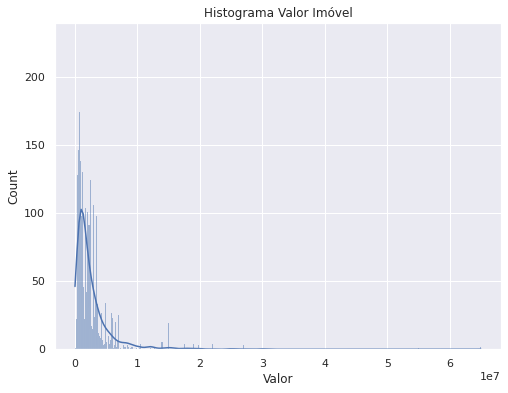

In [169]:
sns.set()
plt.figure(figsize = (8, 6))
ax = sns.histplot(data = dados_vendas_censo, x = 'Valor', bins = 1000, kde = True)
ax.set_title('Histograma Valor Imóvel')
plt.show()

✴ Com esse Histograma percebemos que temos alguns imóveis com valores muito alto, vamos identificar e diminuir a quantidade de outliers da nossa base.

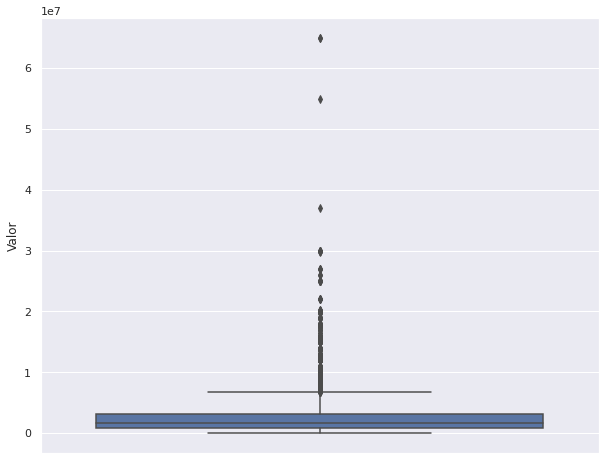

In [170]:
plt.figure(figsize = (10, 8))
ax = sns.boxplot(data = dados_vendas_censo , y = 'Valor')
plt.show()

✴ Para diminuir o "achatamento", iremos trabalhar com imóveis com valor de venda < 10milhões

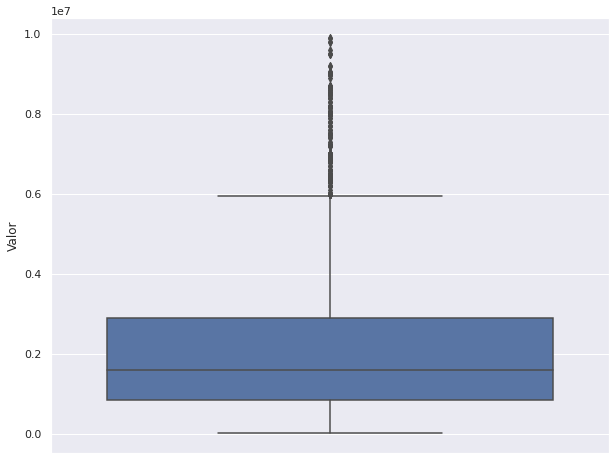

In [171]:
plt.figure(figsize = (10, 8))
ax = sns.boxplot(data = dados_vendas_censo.query('Valor < 10000000') , y = 'Valor')
plt.show()

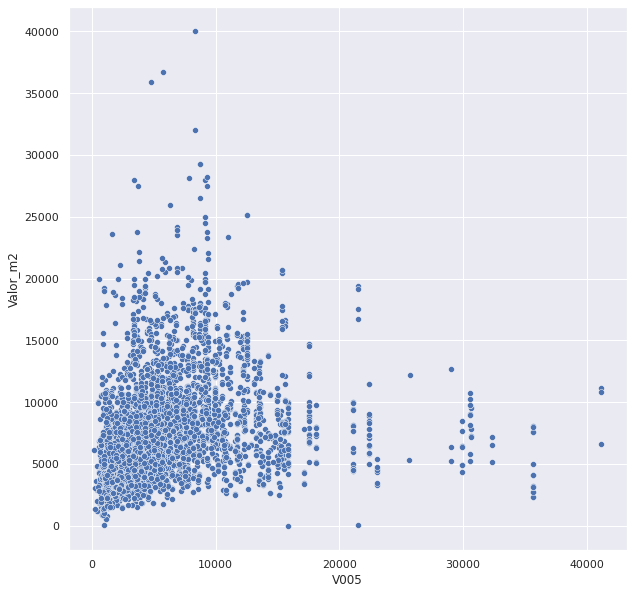

In [172]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data = dados_vendas_censo.query('Valor < 10000000'), x="V005", y="Valor_m2")

✴ Identificamos uma relação entre o Valor do Imóvel versus a renda da Família, isso nos mostra que familias com rendas maiores costumam a comprar imóveis mais caros, não é uma regra pois nosso gráfico de corelação não está muito forte.

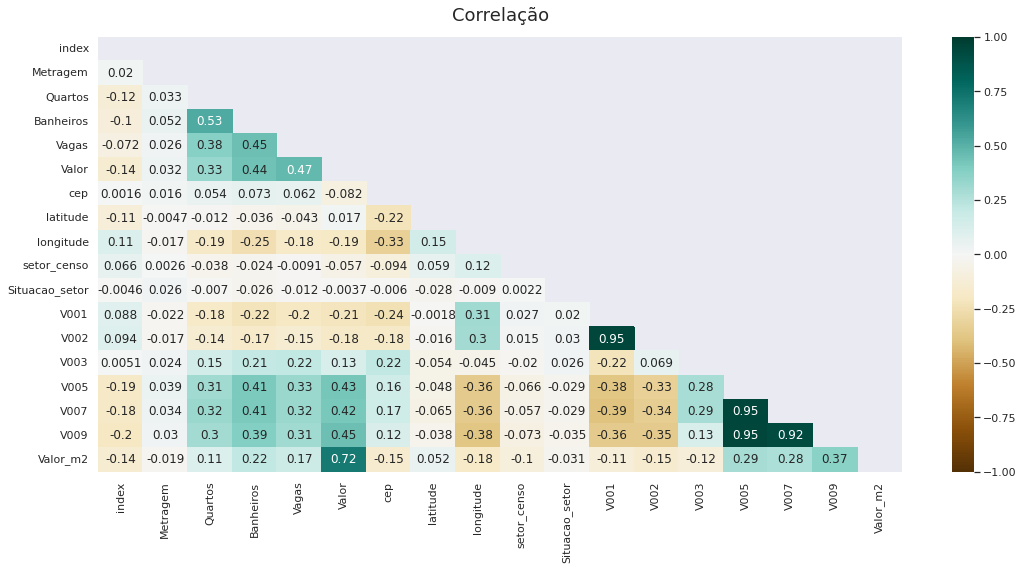

In [173]:
plt.figure(figsize=(18, 8))
#https://www.tylervigen.com/spurious-correlations
mask = np.triu(np.ones_like(dados_vendas_censo.corr(), dtype=bool))
heatmap = sns.heatmap(dados_vendas_censo.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação', fontdict={'fontsize':18}, pad=16);

#Parte 5 - Machine Learing

  Com os dados que temos, vamos rodar um Machine Learning para tentar predizer o valor do Imóveil, na primeira tentativa vamos usar apenas os dados fornecedidos pela nossa tabela de venda de imóveis e ver como fica a corelação.

## Apenas Metragem e Valor

In [231]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = dados_vendas_censo[["Metragem"]]
Y = dados_vendas_censo["Valor"]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)
lr = LinearRegression()

In [232]:
X_train

,Metragem
4240,345
403,600
4314,600
2471,120
835,455
...,...
3392,145
3809,203
5143,145
3855,104


In [233]:
lr.fit(X_train, Y_train)

LinearRegression()

In [234]:
Y_predict_test = lr.predict(X_test)

In [235]:
Y_test

4728    500000.00
4997   1730000.00
208    1620000.00
663    2200000.00
4325   8500000.00
          ...    
4554    600000.00
909    2700000.00
3197   2800000.00
2243   1500000.00
2350    975000.00
Name: Valor, Length: 1329, dtype: float64

In [236]:
Y_predict_train = lr.predict(X_train)

In [237]:
Y_train

4240   2300000.00
403    4500000.00
4314   3400000.00
2471    670000.00
835    4500000.00
          ...    
3392    850000.00
3809   1250000.00
5143    550000.00
3855    425000.00
898    2950000.00
Name: Valor, Length: 3984, dtype: float64

In [238]:
mean_absolute_error(Y_test, Y_predict_test)

2058842.620572713

In [239]:
mean_absolute_error(Y_train, Y_predict_train)

2033724.1483288405

## Com dados da tabela vendas e Valor

In [240]:
dados_vendas_censo.dropna(inplace = True)

In [241]:
dados_vendas_censo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5313 entries, 0 to 5312
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           5313 non-null   int64  
 1   Rua             5313 non-null   object 
 2   Bairro          5313 non-null   object 
 3   Cidade          5313 non-null   object 
 4   Metragem        5313 non-null   int64  
 5   Quartos         5313 non-null   int64  
 6   Banheiros       5313 non-null   int64  
 7   Vagas           5313 non-null   int64  
 8   Moeda           5313 non-null   object 
 9   Valor           5313 non-null   float64
 10  Tipo_anuncio    5313 non-null   object 
 11  cep             5313 non-null   float64
 12  latitude        5313 non-null   float64
 13  longitude       5313 non-null   float64
 14  Point           5313 non-null   object 
 15  setor_censo     5313 non-null   int64  
 16  Situacao_setor  5313 non-null   float64
 17  V001            5313 non-null   f

In [242]:
X1 = dados_vendas_censo[["Metragem", "Quartos", "Banheiros", "Vagas"]]
Y1 = dados_vendas_censo["Valor"]


X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.25, random_state = 54)
lr = LinearRegression()

In [243]:
X1_train

,Metragem,Quartos,Banheiros,Vagas
4240,345,3,3,8
403,600,3,7,4
4314,600,3,2,4
2471,120,3,1,1
835,455,4,6,4
...,...,...,...,...
3392,145,2,1,3
3809,203,2,2,2
5143,145,2,2,1
3855,104,2,2,2


In [244]:
lr.fit(X1_train, Y1_train)

LinearRegression()

In [245]:
Y1_predict_test = lr.predict(X1_test)

In [246]:
Y_test

4728    500000.00
4997   1730000.00
208    1620000.00
663    2200000.00
4325   8500000.00
          ...    
4554    600000.00
909    2700000.00
3197   2800000.00
2243   1500000.00
2350    975000.00
Name: Valor, Length: 1329, dtype: float64

In [247]:
Y1_predict_train = lr.predict(X1_train)

In [248]:
Y1_train

4240   2300000.00
403    4500000.00
4314   3400000.00
2471    670000.00
835    4500000.00
          ...    
3392    850000.00
3809   1250000.00
5143    550000.00
3855    425000.00
898    2950000.00
Name: Valor, Length: 3984, dtype: float64

In [249]:
mean_absolute_error(Y1_test, Y1_predict_test)

1588705.2243309119

In [250]:
mean_absolute_error(Y1_train, Y1_predict_train)

1575409.5205962416

##Com todos os dados que temos a disposição

In [251]:
X2 = dados_vendas_censo[["Metragem", "Quartos", "Banheiros", "Vagas", "V001", 'V007', 'V009']]
Y2 = dados_vendas_censo["Valor"]


X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.25, random_state = 54)
lr.fit(X2_train, Y2_train)
Y2_predict_test = lr.predict(X2_test)
Y2_predict_train = lr.predict(X2_train)
mae_test = mean_absolute_error(Y2_test, Y2_predict_test)
r2_test = r2_score(Y2_test, Y2_predict_test)
mae_train = mean_absolute_error(Y2_train, Y2_predict_train)
r2_train = r2_score(Y2_train, Y2_predict_train)

In [252]:
mae_test

1416267.4962355283

In [253]:
mae_train

1429654.444431393

In [254]:
r2_test

0.38987584382806806

In [255]:
r2_train

0.34857591207027605

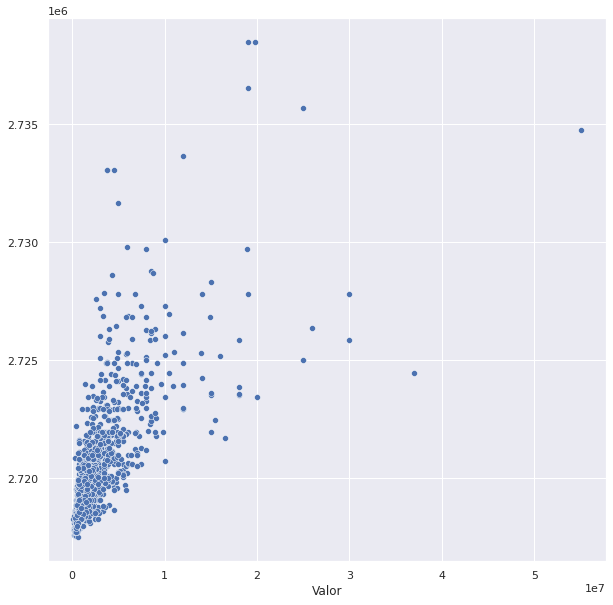

In [256]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=Y_test, y=Y_predict_test)

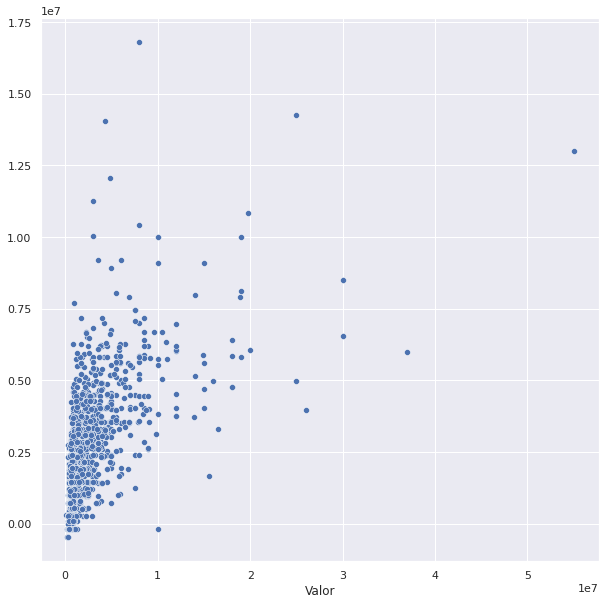

In [257]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=Y1_test, y=Y1_predict_test)

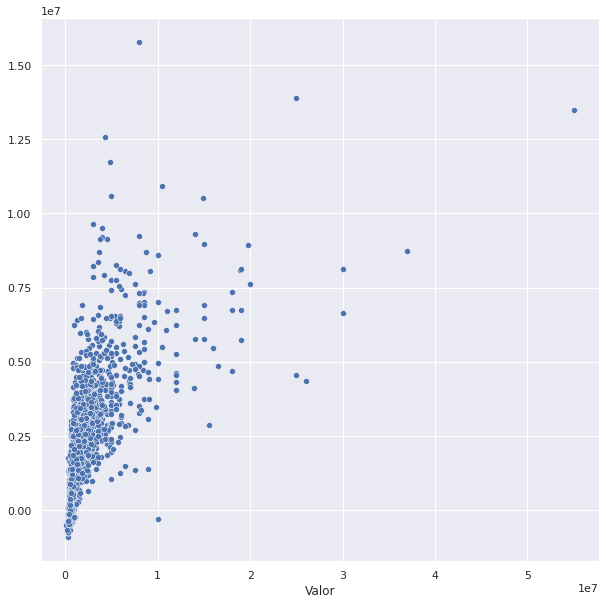

In [258]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=Y2_test, y=Y2_predict_test)

✴ Como podemos observar nos gráficos, talvez esses dados não sejam os melhores para esse tipo de analise, tivemos um corelação crescente mas ainda muito fraca, o ideal seria aumentar nossos números de dados e ter informações mais precisas sem tantos outliers.